In [1]:
import pandas as pd
import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F
import os
import numpy as np
import random
import re
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import eagleSqlTools
from torch.utils.tensorboard import SummaryWriter
import torchvision
from IPython.display import display, HTML
from IPython.display import display
display(HTML("<style>.container { width:70% !important; }</style>"))

from useful_functions_notebook_1to5 import *

In [2]:
dataset = torch.load('data/dataset.pt')

In [3]:
dist_path = "mtrees10_dist"
mass_path = "mtrees10_mass"
subh_path = "mtrees10_subh"

dist_df1 = read_folder(dist_path)
mass_df1 = read_folder(mass_path)
subh_df1 = read_folder(subh_path)

idx_dist, dist_values = zip(*dist_df1)
idx_mass, mass_values = zip(*mass_df1)
idx_subhalo, subh_values = zip(*subh_df1)

are_lists_same = idx_dist == idx_mass == idx_subhalo
print("Are different data variables sorted the same:", are_lists_same)

dist_values = torch.stack(list(dist_values))
mass_values = torch.stack(list(mass_values))
subh_values = torch.stack(list(subh_values))

dataset = torch.stack([dist_values, mass_values, subh_values])
test_dataset = dataset

snap = dataset.shape[2]
branches = dataset.shape[3]

print("Shape of merged tensor = ", [dim for dim in dataset.shape])
print("This is equal to [num variables, num datapoints, rows, columns]")
print("The 3 variables are in the order: dist, mass, subh\n")

print(f"One image has size [{snap, branches}] = [snapshot, branch]")

Are different data variables sorted the same: True
Shape of merged tensor =  [3, 38348, 29, 10]
This is equal to [num variables, num datapoints, rows, columns]
The 3 variables are in the order: dist, mass, subh

One image has size [(29, 10)] = [snapshot, branch]


In [4]:
test_dataset = dataset
normalized_dataset_minus_one_one = normalize(test_dataset, False, [0, 1])

not minmax
not minmax
not normalize


In [5]:
dataset_minus_one_one = normalized_dataset_minus_one_one.permute(1, 0, 2 , 3)
dataset_minus_one_one.shape
torch.save(dataset_minus_one_one, 'data/dataset_minus_one_one.pt')
print("Saved [-1,1] normalized dataset as dataset_minus_one_one.pt")

Saved [-1,1] normalized dataset as dataset_minus_one_one.pt


In [6]:
dataset = torch.load('data/dataset.pt')
normalized_dataset_zero_one = normalize(test_dataset, True, [0, 1])
print(normalized_dataset_zero_one.shape)
print("min:", normalized_dataset_zero_one.min())
print("max:", normalized_dataset_zero_one.max())
dataset_zero_one = normalized_dataset_zero_one.permute(1, 0, 2, 3)
print(dataset_zero_one.shape)

minmax
minmax
not normalize
torch.Size([3, 38348, 29, 10])
min: tensor(0., dtype=torch.float64)
max: tensor(1., dtype=torch.float64)
torch.Size([38348, 3, 29, 10])


In [7]:
#torch.save(dataset_zero_one, 'data/dataset_zero_one.pt')
print("Saved [0,1] normalized dataset as dataset_zero_one.pt")

Saved [0,1] normalized dataset as dataset_zero_one.pt


In [8]:
dataset_real_shape = dataset.permute(1, 0, 2, 3)
five_channel = one_hot_encode_tensor(dataset_real_shape)

In [9]:
#torch.save(five_channel, 'data/five_channel.pt')
print("Saved one-hot encoded dataset with 5 channels as five_channel_one_one.pt")

Saved one-hot encoded dataset with 5 channels as five_channel_one_one.pt


In [10]:
dataset_standard_normalized = torch.load('data/dataset_distlognorm_massnorm.pt')
dataset_standard_normalized.shape

torch.Size([38348, 3, 29, 10])

In [11]:
five_channel_standard_normalized =  one_hot_encode_tensor(dataset_standard_normalized)
#torch.save(five_channel_standard_normalized, 'data/five_channel_distlognorm_massnorm.pt')
print("Saved")

Saved


In [12]:
dataset_one_one = torch.load('data/dataset_distlognorm_massnorm.pt')
print(dataset_one_one.shape)
assert dataset_one_one.shape == torch.Size([38348, 3, 29, 10])

torch.Size([38348, 3, 29, 10])


In [15]:
five_channel = torch.load('data/five_channel_distlognorm_massnorm.pt')
print(five_channel.shape)
assert five_channel.shape == torch.Size([38348, 5, 29, 10])

torch.Size([38348, 5, 29, 10])


In [16]:
assert torch.sum(five_channel[0, 2] + five_channel[0, 3] + five_channel[0, 4]) == 29 * 10

In [17]:
reversed_data = reverse_one_hot_tensor(five_channel)
print(reversed_data.shape)
assert reversed_data.shape == torch.Size([38348, 3, 29, 10])
assert torch.equal(dataset_one_one, reversed_data)
print("reversed is identical to the original data before one hot encoding:", torch.equal(dataset_one_one, reversed_data))

torch.Size([38348, 3, 29, 10])
reversed is identical to the original data before one hot encoding: True


In [18]:
six = torch.load('data/six_branches_data.pt')
dist = six[:, 0]
mass = six[:, 1]
print(dist.min(), dist.max(), dist.mean())
print(mass.min(), mass.max(), mass.mean())

tensor(0., dtype=torch.float64) tensor(1.0919, dtype=torch.float64) tensor(0.0070, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(10.8590, dtype=torch.float64) tensor(1.8114, dtype=torch.float64)


In [19]:
min_values_mass = mass.min()
max_values_mass = mass.max()
mass_normalized = (mass - min_values_mass) / (max_values_mass - min_values_mass)

six[:, 1] = mass_normalized


def log_normalization(tensor, in_scale = 1, in_add = 1):
    return torch.log10(in_scale * tensor + in_add)

scale_in_dist = 1000

log_normalized_dist = log_normalization(dist, in_scale = scale_in_dist)
min_values_log_dist = log_normalized_dist.min()
max_values_log_dist = log_normalized_dist.max()
logg_dist_normalized = (log_normalized_dist - min_values_log_dist) / (max_values_log_dist - min_values_log_dist)

six[:, 0] = logg_dist_normalized

dist_norm = six[:, 0]
mass_norm = six[:, 1]
print(dist_norm.min(), dist_norm.max(), dist_norm.mean())
print(mass_norm.min(), mass_norm.max(), mass_norm.mean())

tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0.0633, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0.1668, dtype=torch.float64)


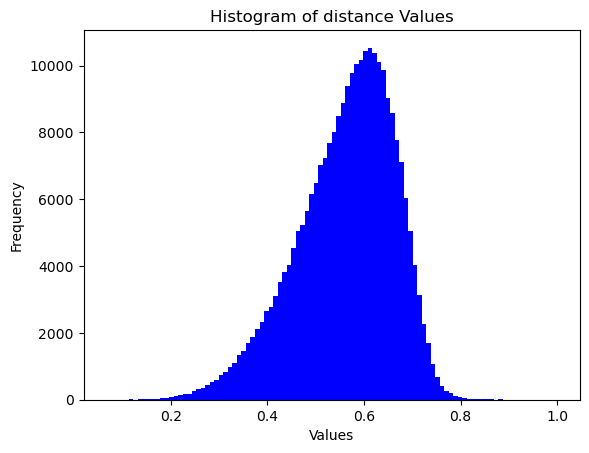

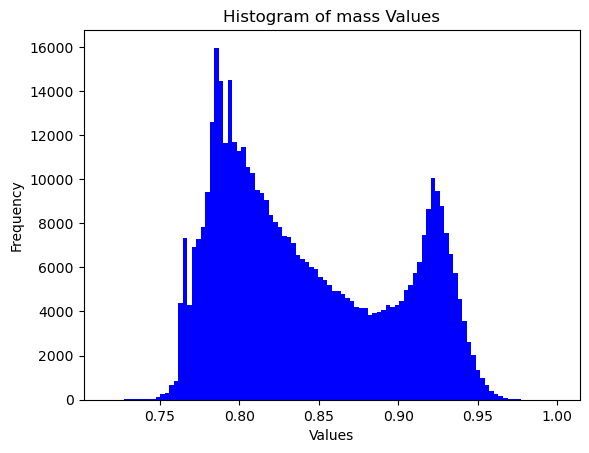

In [20]:
dist_norm_indices = torch.nonzero(dist_norm.flatten())
dist_norm_nonzero = dist_norm.flatten()[dist_norm_indices[:, 0]]
plt.hist(dist_norm_nonzero.flatten().numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of distance Values')

# Show the plot
plt.show()

mass_norm_indices = torch.nonzero(mass_norm.flatten())
mass_norm_nonzero = mass_norm.flatten()[mass_norm_indices[:, 0]]
plt.hist(mass_norm_nonzero.flatten().numpy(), bins=100, color='blue')

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of mass Values')

# Show the plot
plt.show()

In [21]:
#torch.save(six, 'data/six_branch_norm.pt')
print("saved")

saved
